# Fare Play: An Unraveling of the Mystery of Flight Prices

by: Mark Dunlea Tate, Landry Houston, Anthony Amadasun

---

## 2.1 Introduction

This section explores the intricate details of flight prices, exploring various factors that affect price variation. We examine how different airlines employ various pricing strategies to attract customers and maximize their profits. Our analysis covers aspects such as airline preferences, departure times, destinations, and more. We aim to gain insights into the patterns and correlations within the dataset, providing a comprehensive understanding of how different features influence flight prices.

---

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import folium
import plotly.express as px

Read and assign data set.

In [131]:
df = pd.read_csv("../data/clean_dataset.csv")
df.head()

,airline,flight,origin,departure_time,stops,arrival_time,destination,class,duration,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,0,130,71.44
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,0,140,71.44
2,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,0,130,71.47
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,0,135,71.46
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,0,140,71.46


---
## 2.2 Data Transformation and Feature Engineering

In [132]:
df.dtypes

airline            object
flight             object
origin             object
departure_time     object
stops               int64
arrival_time       object
destination        object
class               int64
duration            int64
price             float64
dtype: object

In [133]:
# feature engineering
# new feature for the time of day based based of the depature_time

# specify the range for the labels based on the quartiles
duration_bin_edges = [50, 410, 675, 970, 2990]

# define label for each bin
duration_labels = ["Short", "Medium", "Long", "Very Long"]

# create the duration range feature
df["duration_range"] = pd.cut(
    df["duration"], bins=duration_bin_edges, labels=duration_labels, include_lowest=True
)

Convert 'departure_time' to type categorical.

In [134]:
df["departure_time"] = pd.Categorical(df["departure_time"])

Ordinal encoding.

In [135]:
df["departure_time_encoded"] = df["departure_time"].cat.codes
df["duration_range_encoded"] = df["duration_range"].cat.codes

One-Hot Endode columns for better model predictions.

In [136]:
ohe_columns = ['airline', 'origin', 'departure_time', 'arrival_time', 'destination']
encoded_df = pd.get_dummies(df, columns=ohe_columns, prefix=ohe_columns, dtype=int, drop_first=True)

In [137]:
encoded_df.shape

(300153, 33)

---

## 2.3 Analysis/Visuals

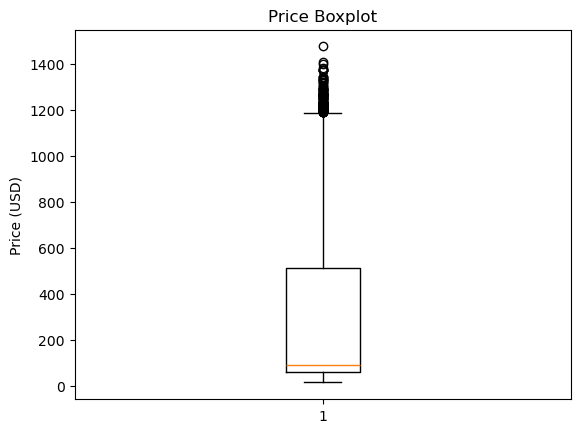

In [138]:
plt.boxplot(df["price"])
plt.title("Price Boxplot")
plt.ylabel("Price (USD)")
plt.savefig("../images/distribution_price_boxplot.png", bbox_inches="tight")

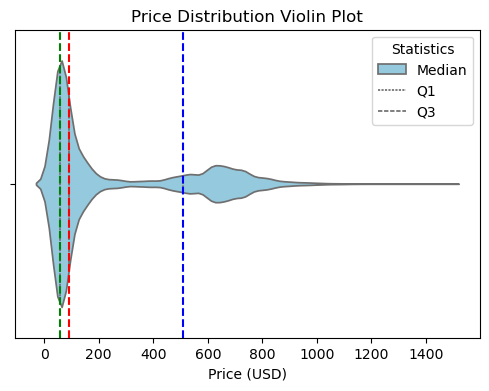

In [139]:
plt.figure(figsize=(6, 4))

sns.violinplot(x=df["price"], color="skyblue", inner="quartile")

median_val = df["price"].median()
q1_val = df["price"].quantile(0.25)
q3_val = df["price"].quantile(0.75)

plt.axvline(median_val, color="red", linestyle="--")
plt.axvline(q1_val, color="green", linestyle="--")
plt.axvline(q3_val, color="blue", linestyle="--")


plt.title("Price Distribution Violin Plot")
plt.xlabel("Price (USD)")


plt.legend(
    {"Median": median_val, "Q1": q1_val, "Q3": q3_val},
    title="Statistics",
    loc="upper right",
)
plt.savefig("../images/distribution_price_violinplot.png", bbox_inches="tight")

### Average Airline Price

C:\Users\cowbo\AppData\Local\Temp\ipykernel_35240\3960837360.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




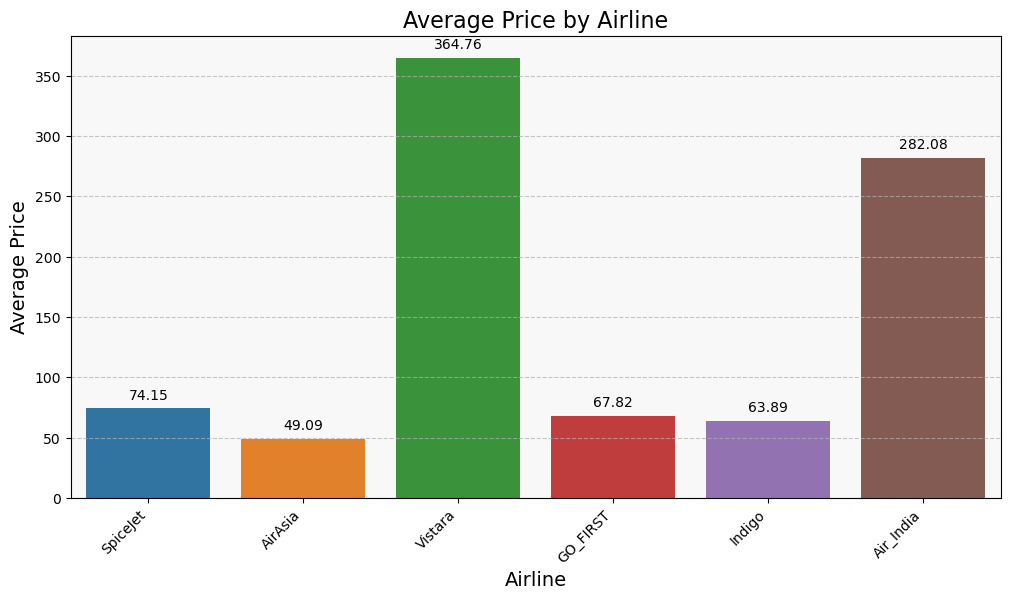

In [140]:
temp1_list = []
temp2_list = []
for i in df["airline"].unique():
    # print(f"airline {i} average price is {df.groupby('airline').get_group(i)['price'].mean()}")
    temp1_list.append(i)
    temp2_list.append(df.groupby("airline").get_group(i)["price"].mean())

plt.figure(figsize=(12, 6))
sns.barplot(x=temp1_list, y=temp2_list, palette="tab10")

plt.xticks(rotation=45, ha="right")

plt.xlabel("Airline", fontsize=14)
plt.ylabel("Average Price", fontsize=14)
plt.title("Average Price by Airline", fontsize=16)

# Add data labels on top of each bar
for i, v in enumerate(temp2_list):
    plt.text(i, v + 5, round(v, 2), ha="center", va="bottom", fontsize=10)

plt.gca().set_facecolor("#f8f8f8")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("../images/average_price_airline.png", bbox_inches="tight");

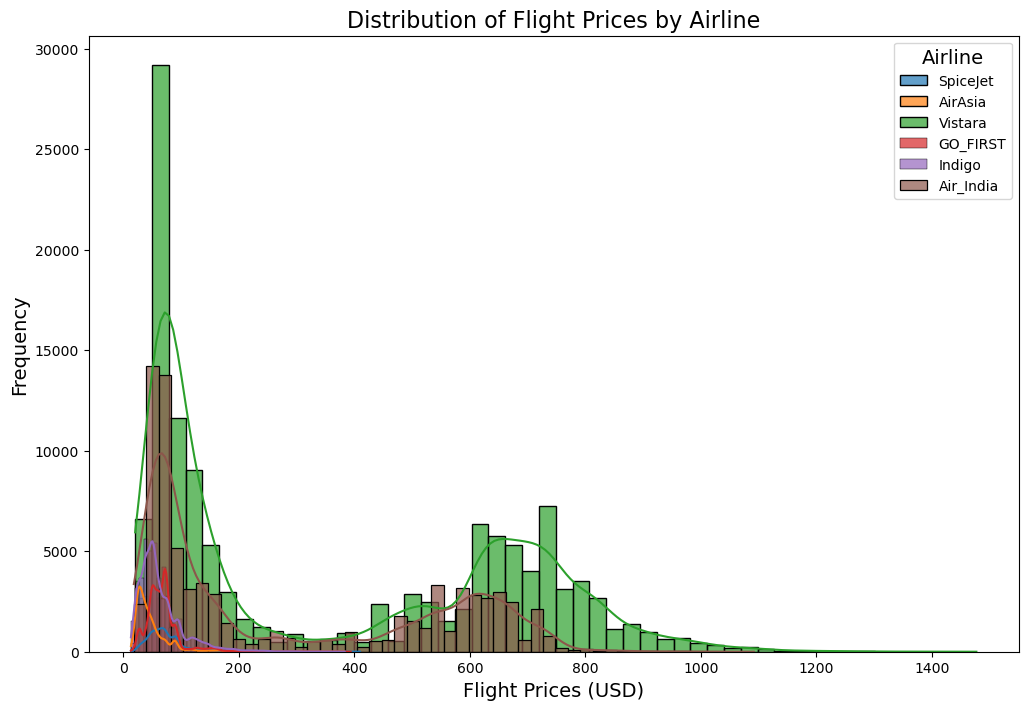

In [141]:
plt.figure(figsize=(12, 8))

for i, airline in enumerate(df["airline"].unique()):
    prices = df.groupby("airline").get_group(airline)["price"]
    sns.histplot(
        prices, bins=50, label=airline, alpha=0.7, color=plt.cm.tab10(i), kde=True
    )

plt.xlabel("Flight Prices (USD)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Flight Prices by Airline", fontsize=16)
plt.legend(title="Airline", title_fontsize="14", fontsize="10", loc="upper right")
plt.savefig("../images/distribution_price_airline.png", bbox_inches="tight")

**Interpretation:**

- The airline Vistara has the highest average ticket price among all other airline in India, this may appeal to customers who is looking for a more luxurious travel experience. Air India also position itself as a premium airline that offers premium service and amenities.
- AirAsia standouts as the lowest average ticket price, making it at attractive option for budget-conscious travelers
- Indigo, Spicejet, and GO_FIRST offer competitive average pricing, making them potential choices for cost-sensitive travelers and travelers looking for a combination of affordability and service.

The 2nd chart(histogram) illustrates how flight prices vary across different airlines. SpiceJet, AirAsia, GO_FIRST, and Indigo histogram shows a concentration of lower-priced flights, indicating a focus on budget friendly option. While Vistera and Air India pricing distribution is more spread out, with a significant presence in the mid to higher price ranges. These two airline highlights a  a diverse set of flight options catering to different preferences.

### Class Analysis

As expected, traveling first class is substantially more expensive.

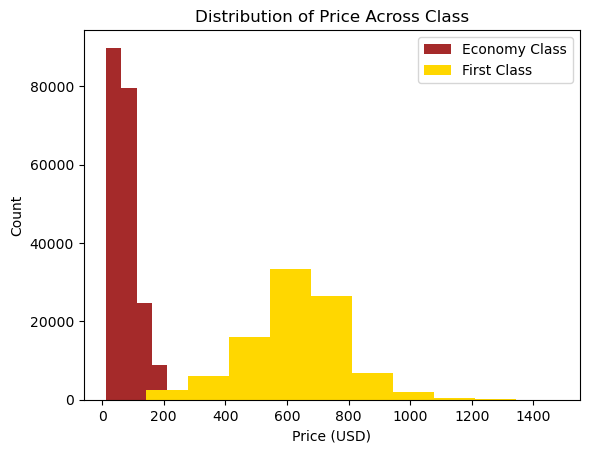

In [142]:
plt.hist(
    df.groupby("class").get_group(0)["price"], color="brown", label="Economy Class"
)
plt.hist(df.groupby("class").get_group(1)["price"], color="gold", label="First Class")
plt.title("Distribution of Price Across Class")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.legend()
plt.savefig("../images/distribution_price_class.png", bbox_inches="tight")

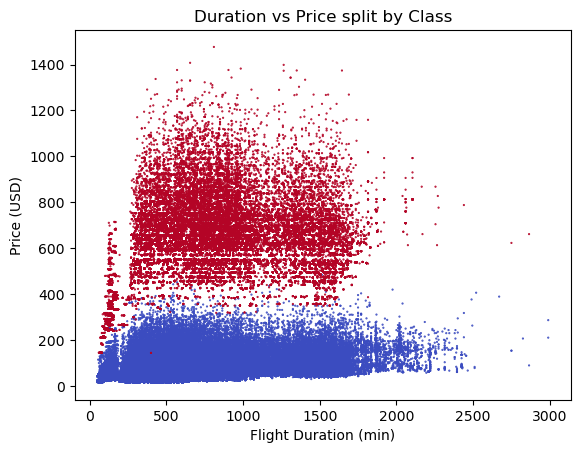

In [143]:
econ = df.groupby("class").get_group(0)
first = df.groupby("class").get_group(1)
plt.scatter(df["duration"], df["price"], c=df["class"], cmap="coolwarm", s=0.3)
plt.title("Duration vs Price split by Class")
plt.ylabel("Price (USD)")
plt.xlabel("Flight Duration (min)")
plt.savefig("../images/duration_price_class.png", bbox_inches="tight")

### Stops Analysis
As can be seen by the histogram trips with one stop likely are the most expensive, because they are the most frequently used so demand for this style must be quite high

to city 0 average price is 112.51175424952784
to city 1 average price is 274.8120197876929
to city 2 average price is 169.36129534848712


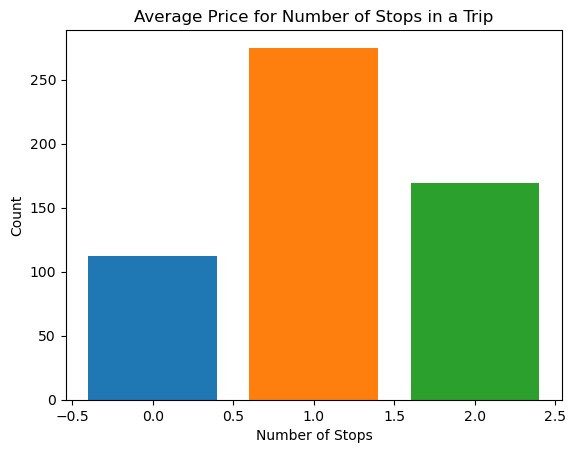

In [144]:
temp1_list = []
temp2_list = []
for i in df["stops"].unique():
    print(
        f"to city {i} average price is {df.groupby('stops').get_group(i)['price'].mean()}"
    )
    temp1_list.append(i)
    temp2_list.append(df.groupby("stops").get_group(i)["price"].mean())

plt.bar(temp1_list, temp2_list, color=plt.cm.tab10([i for i in df["stops"].unique()]))
plt.title("Average Price for Number of Stops in a Trip")
plt.xlabel("Number of Stops")
plt.ylabel("Count")
plt.savefig("../images/avg_price_stops.png", bbox_inches="tight")

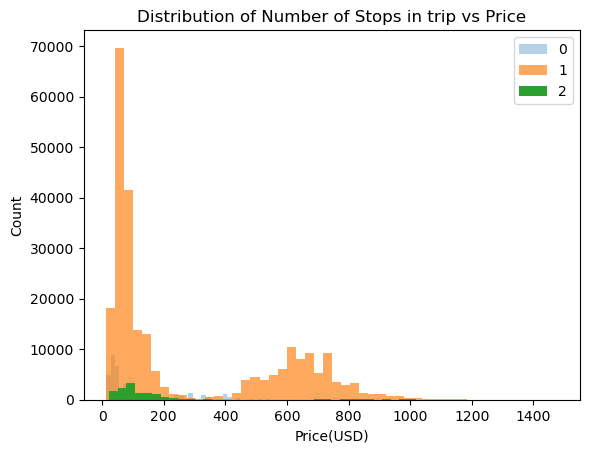

In [145]:
count = 0
for i in df["stops"].unique():
    count += 1
    plt.hist(
        df.groupby("stops").get_group(i)["price"],
        bins=50,
        label=i,
        alpha=count / (len(df["stops"].unique())),
    )
    plt.legend()

plt.title("Distribution of Number of Stops in trip vs Price")
plt.xlabel("Price(USD)")
plt.ylabel("Count")
plt.savefig("../images/distribution_stops_price.png", bbox_inches="tight")

### Average price by Origin City

C:\Users\cowbo\AppData\Local\Temp\ipykernel_35240\2546136155.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




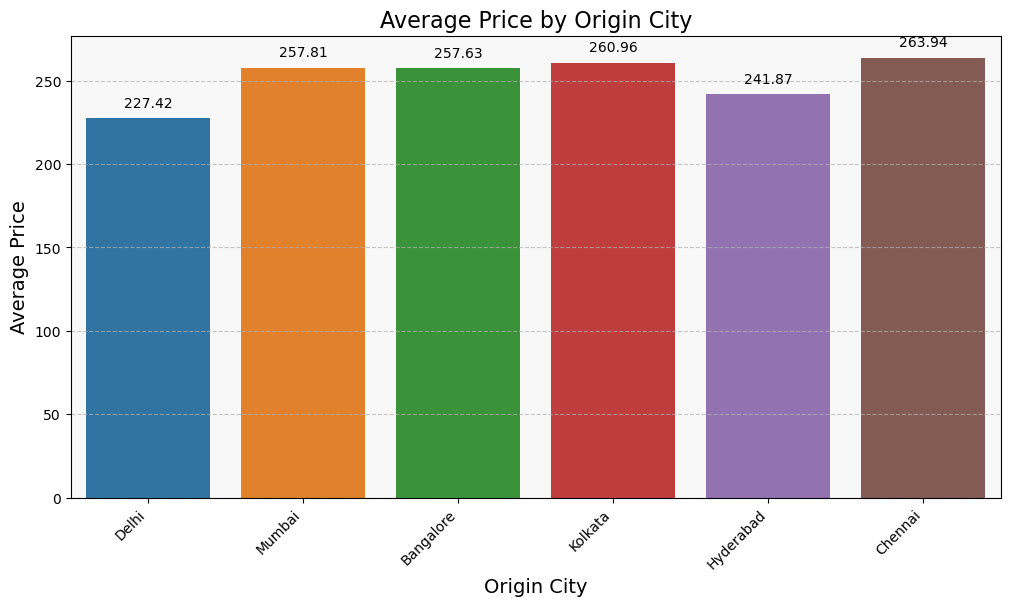

In [146]:
temp3_list = []
temp4_list = []
for i in df["origin"].unique():
    # print(f"from city {i} average price is {df.groupby('origin').get_group(i)['price'].mean()}")
    temp3_list.append(i)
    temp4_list.append(df.groupby("origin").get_group(i)["price"].mean())

plt.figure(figsize=(12, 6))
sns.barplot(x=temp3_list, y=temp4_list, palette="tab10")

plt.xticks(rotation=45, ha="right")

plt.xlabel("Origin City", fontsize=14)
plt.ylabel("Average Price", fontsize=14)
plt.title("Average Price by Origin City", fontsize=16)

# Add data labels on top of each bar
# code logic : https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart
for i, v in enumerate(temp4_list):
    plt.text(i, v + 5, round(v, 2), ha="center", va="bottom", fontsize=10)

# change plot background
plt.gca().set_facecolor("#f8f8f8")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("../images/avg_price_origin_city.png", bbox_inches="tight")

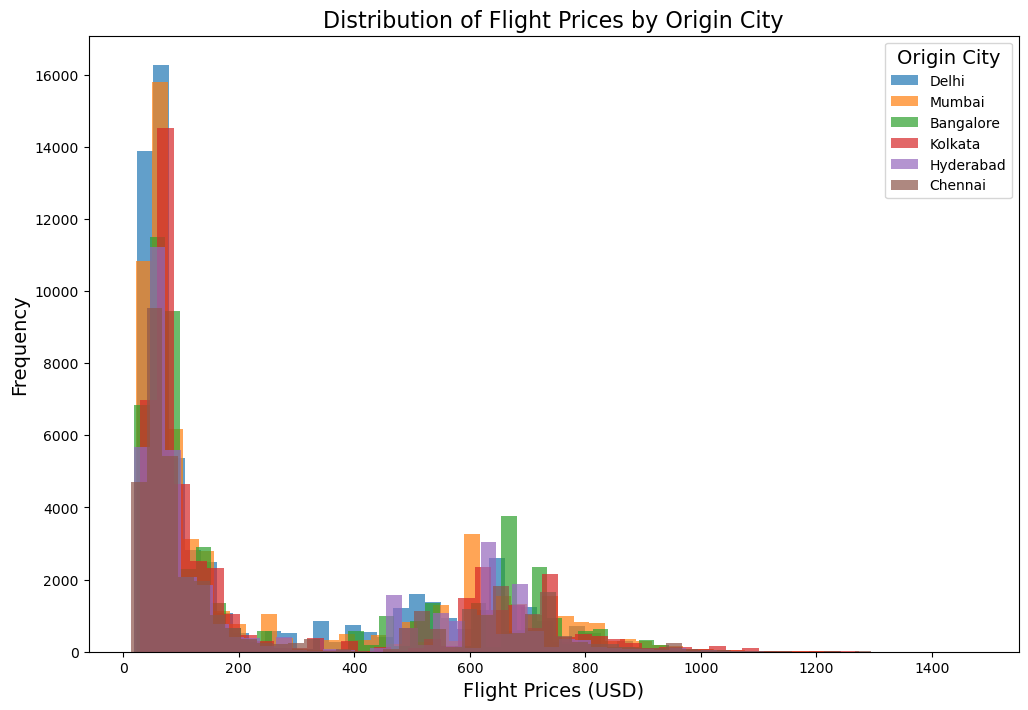

In [147]:
plt.figure(figsize=(12, 8))

for i, origin in enumerate(df["origin"].unique()):
    prices = df.groupby("origin").get_group(origin)["price"]
    plt.hist(
        prices, bins=50, label=origin, alpha=0.7, color=plt.cm.tab10(i)
    )  # sns visual conflict, have to use plt.hist

plt.xlabel("Flight Prices (USD)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Flight Prices by Origin City", fontsize=16)
plt.legend(title="Origin City", title_fontsize="14", fontsize="10", loc="upper right")
plt.savefig("../images/distribution_price_origin_city.png", bbox_inches="tight")

**Interpretation:**

- Delhi: average flight price from Delhi is approximately 227.42
- Mumbai: average flight price of around 257.81.
- Bangalore: the average price is approximately 257.63.
- Kolkata: average flight price of about 260.96.
- Hyderabad: average price of around 241.87.
- Chennai: average flight price is approximately 263.94.

The 2nd chart (histogram) illustrates the distribution of flight prices across different origin cities. Each color-coded bar corresponds to a specific city, which helps provide insights into the variation in pricing patterns.The majority of flights from each city falls between the 50 and 200 range. Flights from Bangalore and Mumbai displays a bimodal distribution, indicating two distinct groups of flight prices. There's a notable cluster of lower-priced flights, while another cluster suggests higher-priced options. Cities like Delhi and Kolkata show a skewed distribution towards the lower price range, indicating a prevalence of budget-friendly options. However, Kolkata have some higher-priced flights, contributing to a wider spread in pricing. Chennai and Hyderabad suggests a relatively even distribution of flight prices, with no prominent peaks, suggesting a balanced spread of prices for flights


### Average Price by Depature Time

C:\Users\cowbo\AppData\Local\Temp\ipykernel_35240\3562387183.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\cowbo\AppData\Local\Temp\ipykernel_35240\3562387183.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




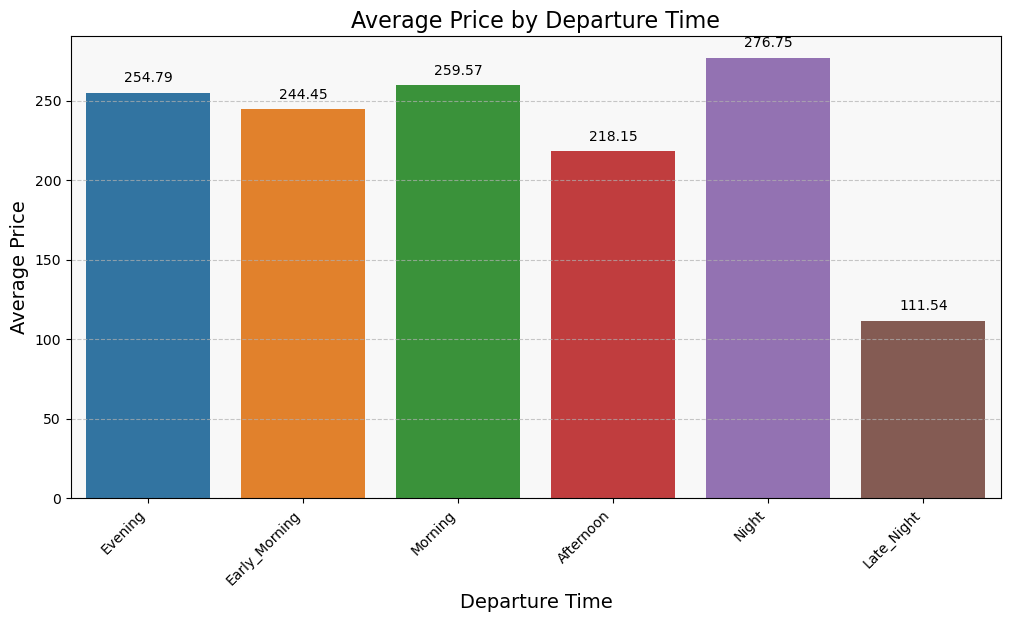

In [148]:
temp5_list = []
temp6_list = []

for i in df["departure_time"].unique():
    # print(f"departure time {i} average price is {df.groupby('departure_time').get_group(i)['price'].mean()}")
    temp5_list.append(i)
    temp6_list.append(df.groupby("departure_time").get_group(i)["price"].mean())

plt.figure(figsize=(12, 6))
sns.barplot(x=temp5_list, y=temp6_list, palette="tab10")


plt.xticks(rotation=45, ha="right")

plt.xlabel("Departure Time", fontsize=14)
plt.ylabel("Average Price", fontsize=14)
plt.title("Average Price by Departure Time", fontsize=16)

# Add data labels on top of each bar
for i, v in enumerate(temp6_list):
    plt.text(i, v + 5, round(v, 2), ha="center", va="bottom", fontsize=10)

# Customize background color and gridlines
plt.gca().set_facecolor("#f8f8f8")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("../images/avg_price_departure_time.png", bbox_inches="tight")

C:\Users\cowbo\AppData\Local\Temp\ipykernel_35240\3815857684.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



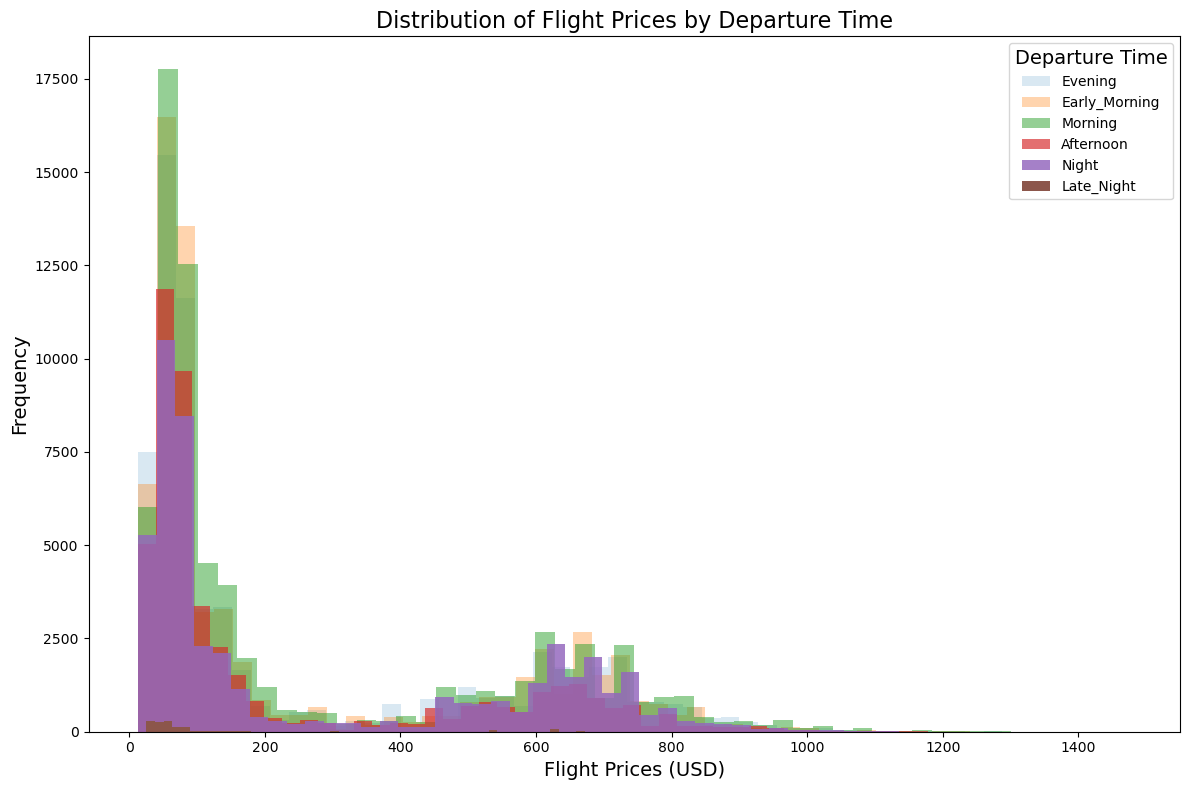

In [149]:
count = 0

plt.figure(figsize=(12, 8))
for i, departure_time in enumerate(df["departure_time"].unique()):
    count += 1
    prices = df.groupby("departure_time").get_group(departure_time)["price"]
    plt.hist(
        prices,
        bins=50,
        label=departure_time,
        alpha=count / (len(df["departure_time"].unique())),
    )

plt.xlabel("Flight Prices (USD)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Flight Prices by Departure Time", fontsize=16)

plt.legend(
    title="Departure Time", title_fontsize="14", fontsize="10", loc="upper right"
)

plt.tight_layout()
plt.savefig("../images/distribution_price_departure_time.png", bbox_inches="tight")

**Interpretation:**

The bar chart shows that late night flights are cheapest and early night flight are most expensive. 
- Evening:  average price is 254.79
- Early Morning:  average price is 244.45
- Morning: average price is 259.57
- Afternoon: average price is 218.15
- Night: average price is 276.74
- Late Night: average price is 111.54

The histogram shows the distribution of flight prices for different departure times. The plot shows that flight price in the morning andafternoon tend to be cheaper than flights in evening and nights.


#### Correlation Matrix

In [150]:
columns_for_corr = [
    "stops",
    "class",
    "price",
    "departure_time_encoded",
    "duration_range_encoded",
    "destination_Chennai",
    "destination_Delhi",
    "destination_Hyderabad",
    "destination_Kolkata",
    "destination_Mumbai",
]

corr_matrix = encoded_df[columns_for_corr].corr()
corr_matrix

,stops,class,price,departure_time_encoded,duration_range_encoded,destination_Chennai,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_Mumbai
stops,1.000000,0.001027,0.119648,-0.031022,0.442084,0.060865,-0.104565,0.029073,0.062722,-0.046849
class,0.001027,1.000000,0.937860,0.053340,0.166950,0.012331,-0.021200,0.007564,-0.012987,0.010573
price,0.119648,0.937860,1.000000,0.058319,0.231475,0.018473,-0.052527,-0.008292,0.020956,0.010534
departure_time_encoded,-0.031022,0.053340,0.058319,1.000000,0.108320,-0.004448,0.014537,0.006081,-0.008285,-0.003550
duration_range_encoded,0.442084,0.166950,0.231475,0.108320,1.000000,0.062580,-0.113957,0.069288,0.047905,-0.042666
destination_Chennai,0.060865,0.012331,0.018473,-0.004448,0.062580,1.000000,-0.191601,-0.160594,-0.175249,-0.195180
destination_Delhi,-0.104565,-0.021200,-0.052527,0.014537,-0.113957,-0.191601,1.000000,-0.198018,-0.216088,-0.240664
destination_Hyderabad,0.029073,0.007564,-0.008292,0.006081,0.069288,-0.160594,-0.198018,1.000000,-0.181119,-0.201717
destination_Kolkata,0.062722,-0.012987,0.020956,-0.008285,0.047905,-0.175249,-0.216088,-0.181119,1.000000,-0.220125
destination_Mumbai,-0.046849,0.010573,0.010534,-0.003550,-0.042666,-0.195180,-0.240664,-0.201717,-0.220125,1.000000


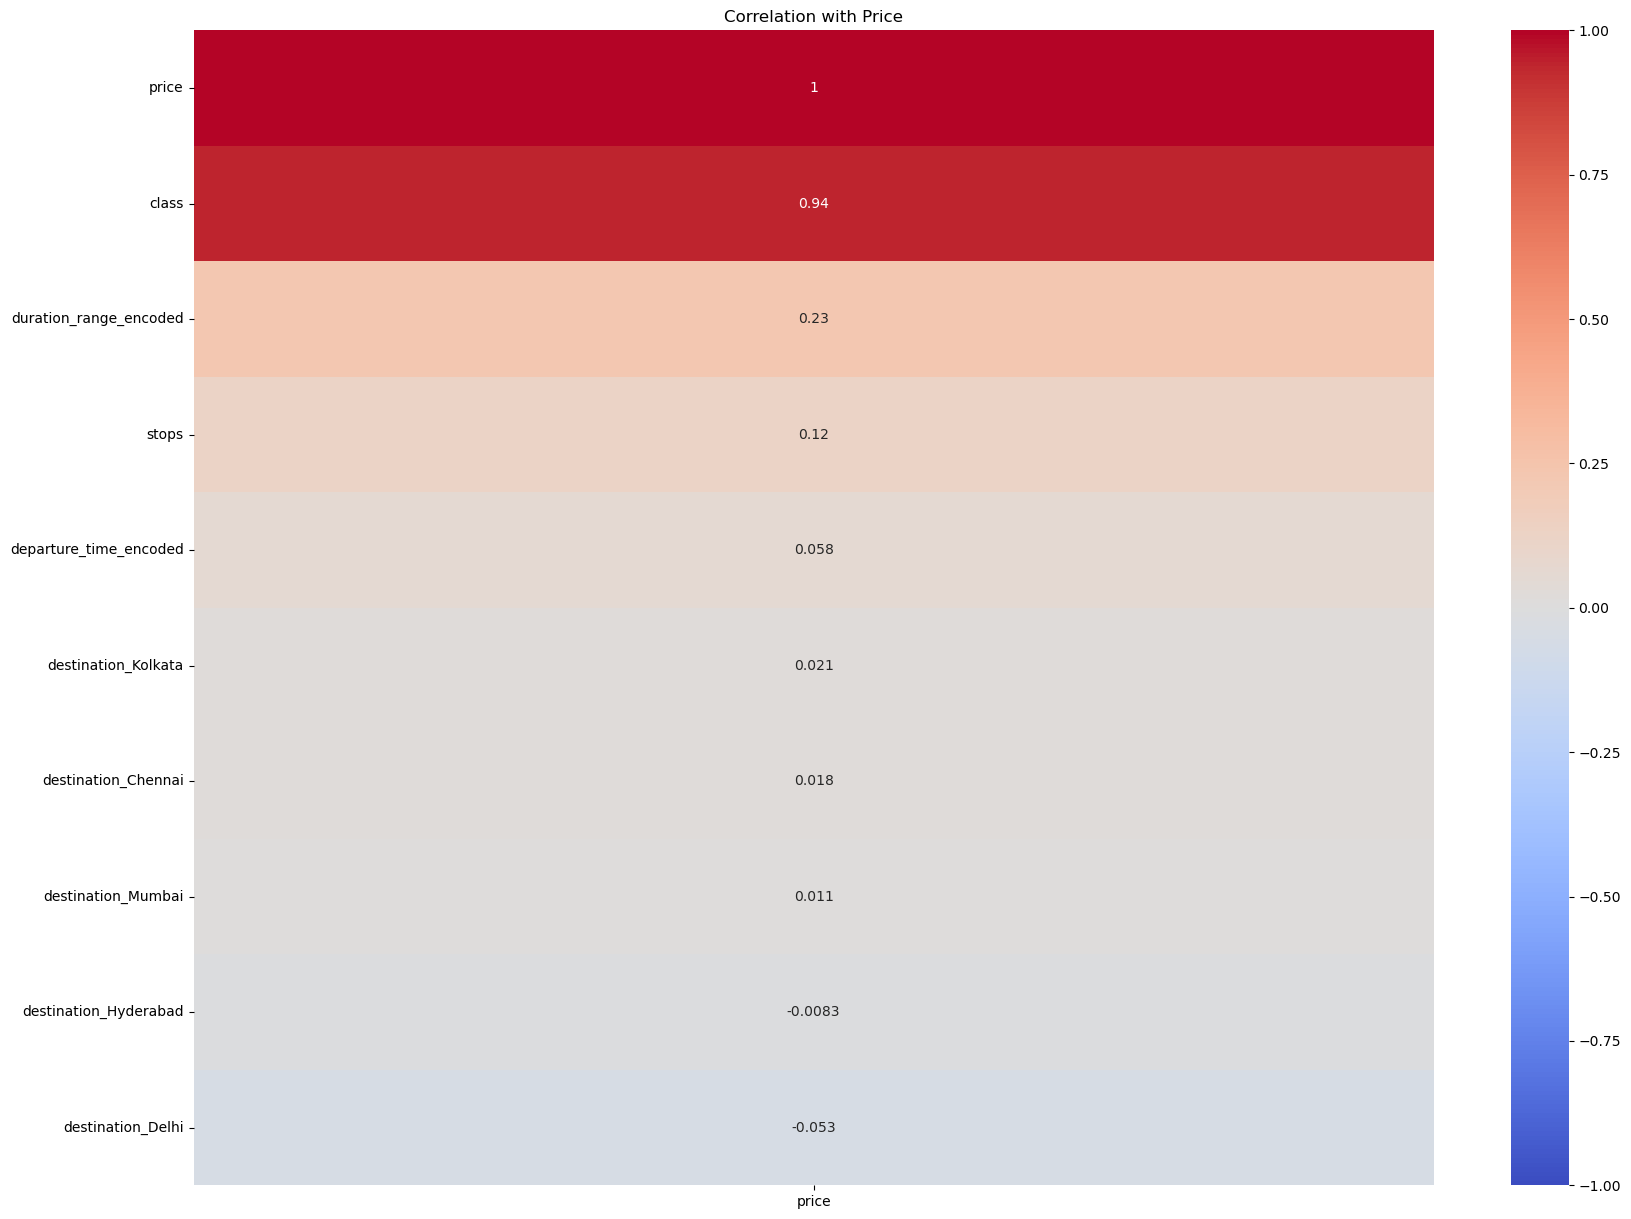

In [151]:
plt.figure(figsize=(20, 15))
plt.title("Correlation with Price")

heatmap = sns.heatmap(
    corr_matrix[["price"]].sort_values(by="price", ascending=False),
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=True,
)
plt.savefig("../images/correlation_price.png", bbox_inches="tight")

**Interpretation:**

The class and duration range are the most strongly correlated with flight prices, indicating that these factors have a more significant impact on the variation in flight prices. The number of stops and specific destinations show weaker correlations, implying a less direct influence on flight prices.


### Location Analysis
Location analysis is in comparison of the most central airport Hyderabad

In [152]:
cities = {
    "Delhi": (28.6139, 77.2090),
    "Mumbai": (19.0760, 72.8777),
    "Bangalore": (12.9716, 77.5946),
    "Kolkata": (22.5726, 88.3639),
    "Chennai": (13.0827, 80.2707),
    "Hyderabad": (17.3850, 78.4867),
}

In [153]:
def angle_to_cardinal(angle):
    directions = ["E", "NE", "N", "NW", "W", "SW", "S", "SE", "E"]
    index = round(angle / 45) % 8
    return directions[index]

In [154]:
lat, long = cities["Hyderabad"]
for i in cities:
    x, y = cities[i]
    opp = x - lat
    adj = y - long

    try:
        print(math.degrees(math.atan2(opp, adj)))
        print(i)
        print(angle_to_cardinal(math.degrees(math.atan2(opp, adj))))
    except:
        1

96.49158001814982
Delhi
N
163.22300374631428
Mumbai
W
-101.42747311931137
Bangalore
S
27.70888517059428
Kolkata
NE
-67.478076298245
Chennai
SE
0.0
Hyderabad
E


In [155]:
df["origin_lat_long"] = df["origin"].map(cities)

df["destination_lat_long"] = df["destination"].map(cities)

In [156]:
city_direction = {
    "Delhi": "N",
    "Mumbai": "W",
    "Bangalore": "S",
    "Kolkata": "NE",
    "Chennai": "SE",
    "Hyderabad": "0",
}

df_w_dir = df
df_w_dir["card_direction"] = df["destination"].map(city_direction)

### Feature Engineered Location Columns

In [157]:
lat_list = []
long_list = []

for lat, long in df["origin_lat_long"]:
    lat_list.append(lat)
    long_list.append(long)

df["origin_latitude"] = lat_list
df["origin_longitude"] = long_list

In [158]:
lat_list = []
long_list = []

for lat, long in df["destination_lat_long"]:
    lat_list.append(lat)
    long_list.append(long)

df["destination_latitude"] = lat_list
df["destination_longitude"] = long_list

### Folium Map

In [159]:
new_df = df.sample(frac=0.0005)

map_center = [cities["Hyderabad"][0], cities["Hyderabad"][1]]
folium_map = folium.Map(location=map_center, zoom_start=4)

for index, row in new_df.iterrows():
    folium.Marker(
        [row["origin_latitude"], row["origin_longitude"]], popup=row["origin"]
    ).add_to(folium_map)
    folium.Marker(
        [row["destination_latitude"], row["destination_longitude"]],
        popup=row["destination"],
    ).add_to(folium_map)

folium_map.save("folium_map1.html")

In [160]:
new_df["class_label"] = new_df["class"].map({0: "Economy", 1: "Business"})

sunburst_chart = px.sunburst(
    new_df,
    path=["airline", "class_label"],
    values="price",
    title="Class Analysis",
    # labels={'airline': 'Airline', 'stops': 'Number of Stops', 'price': 'Average Price'},
    hover_data=["price"],
)
sunburst_chart.update_layout(width=900, height=900, legend=dict(title="Legend Title"))

sunburst_chart.show()
plt.savefig("../images/distribution_airline_class.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

**Save dataset to data folder**

In [161]:
encoded_df.to_csv('../data/encoded_dataset.csv', index=False)

---

## 2.4 Conclusion

Notable findings include the presence of outliers above $1200, emphasizing the need to consider airline pricing tendencies in dynamic markets. Vistara and Air India, with significantly higher averages, stand out as major players, driven by their market control, operational scale, and demand for consistent service.

Airport location impacts pricing, with Delhi and Hyderabad offering slightly lower fares, attributed to efficient cost distribution and central positioning, respectively. Mumbai and Delhi emerge as popular destinations, while Hyderabad stands out as a cost-effective departure point due to its central location.

Time analysis reveals night and mid-afternoon departures as more affordable, aligning with lower demand during these periods. First-class travel unsurprisingly commands higher prices. Trips with one stop, being the most frequent, correlate with higher costs, indicating high demand for this travel style.

Correlation analysis identifies attributes like class, airline choice, and duration as most influential. The Folium Map visually displays the locations of analyzed airports, providing geographical context to the findings.

This comprehensive exploration aims to enhance understanding and decision-making in the dynamic realm of airline pricing.